In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import time

from libworm.model.beta_neuron import NeuronNetwork, from_connectome
from libworm.data import connectomes, traces
from libworm import preprocess
from libworm.functions import set_neurons, tcalc_s_inf, set_trace
from libworm.data.neuron import full_sensory_list

import json

from math import tau

In [3]:
_, trace, trace_labels, label2index, timestamps = traces.load_trace()
chemical, gapjn = connectomes.load_cook_connectome()
neurons = connectomes.get_main_neurons(chemical, gapjn)
sorted_neurons = [cell for cell in neurons]
sorted_neurons.sort(key=lambda item: f"AAA{label2index[item]:04d}{item}" if item in label2index else item)

In [4]:
chemical["ADAL"]["ADAL"]

6.0

In [5]:
got_neurons = list(label2index.keys())
labeled_neurons = [cell for cell in got_neurons if cell in neurons]
input_neurons = [cell for cell in labeled_neurons if cell in full_sensory_list]

In [6]:
len(input_neurons)

41

In [7]:
combined = {}

# connect[from][to]

for from_cell in neurons:
    if from_cell in input_neurons:
        combined["sensory"] = {} 
    else:
        combined[from_cell] = {} 
    for to_cell in neurons:
        if from_cell in input_neurons and to_cell in input_neurons:
            pass
        elif from_cell in input_neurons:
            combined["sensory"][to_cell] = chemical[from_cell][to_cell] + gapjn[from_cell][to_cell] 
        elif to_cell in input_neurons:
            combined[from_cell]["sensory"] = chemical[from_cell][to_cell] + gapjn[from_cell][to_cell] 
        else:
            combined[from_cell][to_cell] = chemical[from_cell][to_cell] + gapjn[from_cell][to_cell] 

In [8]:
queue = {"sensory"}
next_queue = set()
visited = {}

depth = 0

while len(queue) != 0:
    element = queue.pop()

    post = {cell for cell, value in combined[element].items() if value != 0}
    not_visited = post - visited.keys() - queue
    if element in not_visited:
        not_visited.remove(element)
    assert(element not in not_visited)
    next_queue.update(not_visited)

    assert(element not in visited)
    visited[element] = depth
    
    if len(queue) == 0 and len(next_queue) != 0:
        queue.update(next_queue)
        next_queue.clear()
        depth += 1


In [9]:
with open("rust/results/evo_test_run_evals.json", "r") as file:
    test_evals = np.array(json.load(file))

In [10]:
len(test_evals)

280

In [11]:
eval_by_dist = []

for i, cell in enumerate(sorted_neurons):
    if cell in visited and test_evals[i] != 0:
        eval_by_dist.append([visited[cell], test_evals[i]])

eval_by_dist = np.array(eval_by_dist)

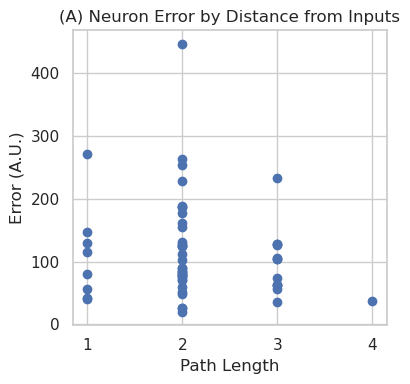

In [13]:
sns.set_theme(style="whitegrid")

plt.title("(A) Neuron Error by Distance from Inputs")
plt.xlabel("Path Length")
plt.ylabel("Error (A.U.)")

fig = plt.gcf()
fig.set_size_inches(4.2, 4)
plt.tight_layout()

plt.scatter(eval_by_dist[:, 0], eval_by_dist[:, 1])

plt.savefig('img/error_dist.png', dpi=150)
plt.show()